In [ ]:
# installation
pip install pandas_profiling

In [151]:
# imports
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns


In [2]:
import io

# récupération du csv
df = pd.read_csv('owid-covid-data.csv')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86418 entries, 0 to 86417
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               86418 non-null  object 
 1   continent                              82253 non-null  object 
 2   location                               86418 non-null  object 
 3   date                                   86418 non-null  object 
 4   total_cases                            84266 non-null  float64
 5   new_cases                              84264 non-null  float64
 6   new_cases_smoothed                     83263 non-null  float64
 7   total_deaths                           74554 non-null  float64
 8   new_deaths                             74712 non-null  float64
 9   new_deaths_smoothed                    83263 non-null  float64
 10  total_cases_per_million                83811 non-null  float64
 11  ne

In [3]:
# création de et connexion à la bdd
conn = sqlite3.connect('brief-data.db')
c = conn.cursor()

In [ ]:
# import du csv dans la bdd (commenté pour éviter d'append plusieurs fois)
# df.to_sql('data', conn, if_exists='append', index=False)

In [108]:
# 1. How many countries are included in our data set?
pd.read_sql_query("""
    SELECT count(DISTINCT location) as 'NOMBRE DE PAYS'
    FROM data;""",conn)

,NOMBRE DE PAYS
0,219


In [110]:
# 2. When was the most recent entry?
pd.read_sql_query("""
    SELECT * FROM data
    ORDER BY date DESC
    LIMIT 1;""",conn)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2021-05-06,61162.0,365.0,226.571,2664.0,10.0,6.571,...,1803.987,None,597.029,9.59,None,None,37.746,0.5,64.83,0.511


In [116]:
# 3. What country had the highest single day deaths per million? 
pd.read_sql_query("""
    SELECT location as 'PAYS', date as 'DATE', new_deaths_per_million as 'MORTS/MILLION'
    FROM data
    ORDER BY new_deaths_per_million DESC
    LIMIT 1;""",conn)

,PAYS,DATE,MORTS/MILLION
0,Ecuador,2020-09-07,218.329


In [114]:
# 4. Select any country. How many times have the deaths per million exceeded 1,000 in one day? 
pd.read_sql_query("""
    SELECT location as 'PAYS' , count(location) as 'NBR DE FOIS'
    FROM data
    WHERE new_deaths_per_million > 1.0 AND location = 'Albania';""",conn)

,PAYS,NBR DE FOIS
0,Albania,278


In [161]:
# 5. Extract the deaths per million for US, France, and India. Plot the time series data and compare results to
#  what the media is currently saying
df_compar = pd.read_sql_query("""
        SELECT date as 'DATE', location as'PAYS', total_deaths_per_million as 'MORTS/MILLION'
        FROM data
        WHERE location IN ('France', 'India', 'United States');
        """, conn)

df_compar['DATE']= df_compar['DATE'].astype(dtype='datetime64[ns]')
df_compar

,DATE,PAYS,MORTS/MILLION
0,2020-01-24,France,NaN
1,2020-01-25,France,NaN
2,2020-01-26,France,NaN
3,2020-01-27,France,NaN
4,2020-01-28,France,NaN
...,...,...,...
1398,2021-05-02,United States,1743.439
1399,2021-05-03,United States,1744.898
1400,2021-05-04,United States,1747.717
1401,2021-05-05,United States,1750.062


In [121]:
# 6. Plot the deaths per million and cases per million by continent for your birthday in 2020. What does the data say?
df_anniv= pd.read_sql_query("""
    SELECT continent as 'CONTINENT', new_deaths_per_million as 'MORTS/MILLION', new_cases_per_million as 'CAS/MILLION'
    FROM data
    WHERE date = '2020-07-30'
    GROUP BY continent;""", conn)
df_anniv

,CONTINENT,MORTS/MILLION,CAS/MILLION
0,None,0.339,12.985
1,Africa,0.319,13.728
2,Asia,0.257,1.772
3,Europe,1.390,31.969
4,North America,0.000,0.000
5,Oceania,0.275,23.726
6,South America,3.385,141.097


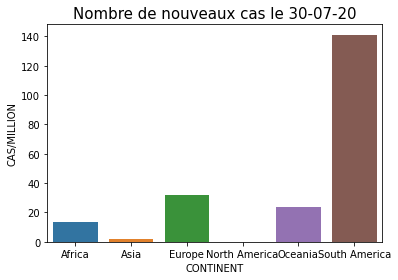

In [144]:
graph_lock= sns.barplot(x="CONTINENT", y="CAS/MILLION", data=df_anniv).set_title('Nombre de nouveaux cas le 30-07-20', size='15');

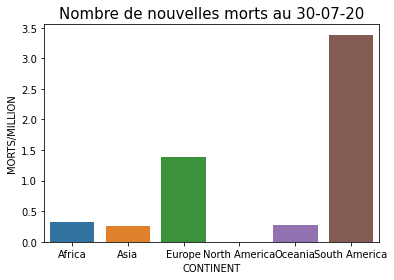

In [141]:
sns.barplot(x="CONTINENT", y="MORTS/MILLION", data=df_anniv).set_title('Nombre de nouvelles morts le 30-07-20', size='15');

In [171]:
# 7. Plot the lockdown stringency for each country and color the scatter points by continent. Any insights?

df_lock= pd.read_sql_query("""
    SELECT continent as 'CONTINENT', location as 'PAYS', hosp_patients as 'HOSPITALISATIONS', stringency_index as 'INDEX DE CONFINEMENT'
    FROM data
    WHERE stringency_index IS NOT NULL;""", conn)

df_lock

,CONTINENT,PAYS,HOSPITALISATIONS,INDEX DE CONFINEMENT
0,Asia,Afghanistan,NaN,8.33
1,Asia,Afghanistan,NaN,8.33
2,Asia,Afghanistan,NaN,8.33
3,Asia,Afghanistan,NaN,8.33
4,Asia,Afghanistan,NaN,8.33
...,...,...,...,...
73332,Africa,Zimbabwe,NaN,51.85
73333,Africa,Zimbabwe,NaN,51.85
73334,Africa,Zimbabwe,NaN,51.85
73335,Africa,Zimbabwe,NaN,51.85


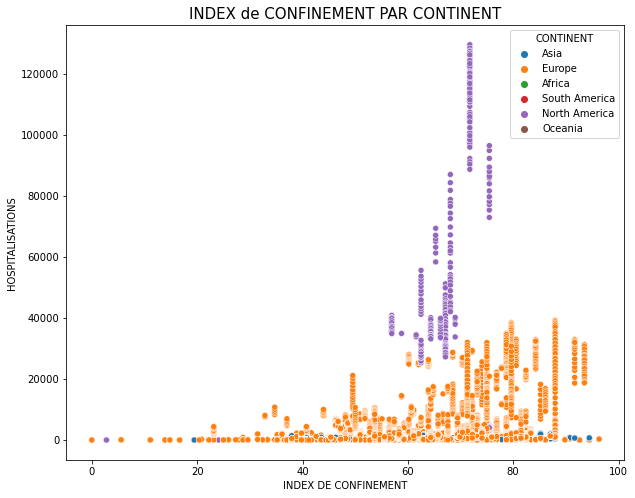

In [157]:
plt.figure(figsize=(10,8))
graph_lock = sns.scatterplot(data=df_lock, x="INDEX DE CONFINEMENT", y="HOSPITALISATIONS", hue="CONTINENT").set_title('INDEX de CONFINEMENT PAR CONTINENT', size='15');